In [38]:
pip install matplotlib shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import shap
import transformers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('training_data.csv')
df = df[~(df['next_week_score_home'].isna())].reset_index(drop=True)# & ~(df['next_week_score_away'].isna())]

In [3]:
team_data = pd.read_csv('team_rolling_data.csv')

In [14]:
df

,Unnamed: 0,schedule_date,schedule_season,schedule_week,schedule_playoff,score_home,score_away,stadium,stadium_neutral,weather_temperature,...,avg_air_yards_share_RB_home_until_week,avg_air_yards_share_RB_away_until_week,avg_air_yards_share_HB_home_until_week,avg_air_yards_share_HB_away_until_week,avg_air_yards_share_FB_home_until_week,avg_air_yards_share_FB_away_until_week,avg_air_yards_share_TE_home_until_week,avg_air_yards_share_TE_away_until_week,avg_air_yards_share_WR_home_until_week,avg_air_yards_share_WR_away_until_week
0,0,9/9/2010,2010,1,False,14,9,Louisiana Superdome,False,72.0,...,14.000000,9.000000,14.000000,9.000000,14.000000,9.000000,14.000000,9.000000,14.000000,9.000000
1,1,9/12/2010,2010,1,False,10,15,Ralph Wilson Stadium,False,64.0,...,10.000000,15.000000,10.000000,15.000000,10.000000,15.000000,10.000000,15.000000,10.000000,15.000000
2,2,9/12/2010,2010,1,False,19,14,Soldier Field,False,75.0,...,19.000000,14.000000,19.000000,14.000000,19.000000,14.000000,19.000000,14.000000,19.000000,14.000000
3,3,9/12/2010,2010,1,False,34,24,Reliant Stadium,False,89.0,...,34.000000,24.000000,34.000000,24.000000,34.000000,24.000000,34.000000,24.000000,34.000000,24.000000
4,4,9/12/2010,2010,1,False,24,17,EverBank Field,False,91.0,...,24.000000,17.000000,24.000000,17.000000,24.000000,17.000000,24.000000,17.000000,24.000000,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,2835,11/5/2023,2023,9,False,30,6,Allegiant Stadium,False,72.0,...,23.222222,17.000000,23.222222,17.000000,23.222222,17.000000,23.222222,17.000000,23.222222,17.000000
2707,2836,11/5/2023,2023,9,False,17,20,Gillette Stadium,False,NaN,...,12.111111,22.625000,12.111111,22.625000,12.111111,22.625000,12.111111,22.625000,12.111111,22.625000
2708,2837,11/5/2023,2023,9,False,24,17,Caesars Superdome,False,72.0,...,25.125000,17.888889,25.125000,17.888889,25.125000,17.888889,25.125000,17.888889,25.125000,17.888889
2709,2838,11/5/2023,2023,9,False,28,23,Lincoln Financial Field,False,NaN,...,30.875000,23.333333,30.875000,23.333333,30.875000,23.333333,30.875000,23.333333,30.875000,23.333333


In [5]:
df.merge(team_data,
         left_on=['schedule_season', 'schedule_week', 'team_home'],
         right_on=['schedule_season', 'schedule_week', 'team'])

,Unnamed: 0_x,schedule_date_x,schedule_season,schedule_week,schedule_playoff_x,team_home_x,score_home_x,score_away_x,team_away_x,team_favorite_id_x,...,avg_air_yards_share_RB_for_until_week,avg_air_yards_share_RB_against_until_week,avg_air_yards_share_HB_for_until_week,avg_air_yards_share_HB_against_until_week,avg_air_yards_share_FB_for_until_week,avg_air_yards_share_FB_against_until_week,avg_air_yards_share_TE_for_until_week,avg_air_yards_share_TE_against_until_week,avg_air_yards_share_WR_for_until_week,avg_air_yards_share_WR_against_until_week
0,0,9/9/2010,2010,1,False,New Orleans Saints,14,9,Minnesota Vikings,NO,...,-0.048583,-0.011070,NaN,NaN,0.016194,NaN,0.089069,0.391144,0.943320,0.619926
1,1,9/12/2010,2010,1,False,Buffalo Bills,10,15,Miami Dolphins,MIA,...,-0.037559,-0.009132,NaN,NaN,NaN,0.031963,NaN,0.109589,1.037559,0.867580
2,2,9/12/2010,2010,1,False,Chicago Bears,19,14,Detroit Lions,CHI,...,0.145455,0.014286,NaN,NaN,NaN,0.000000,0.145455,0.139286,0.709091,0.846429
3,3,9/12/2010,2010,1,False,Houston Texans,34,24,Indianapolis Colts,IND,...,-0.026144,0.037445,NaN,NaN,0.032680,NaN,0.039216,0.171806,0.954248,0.790749
4,4,9/12/2010,2010,1,False,Jacksonville Jaguars,24,17,Denver Broncos,JAX,...,0.006211,0.012422,NaN,NaN,NaN,0.000000,0.142857,0.055901,0.850932,0.931677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,2835,11/5/2023,2023,9,False,Las Vegas Raiders,30,6,New York Giants,LVR,...,0.037777,-0.083663,NaN,NaN,0.023810,0.003282,0.102369,0.184999,0.857208,0.897570
2707,2836,11/5/2023,2023,9,False,New England Patriots,17,20,Washington Commanders,NE,...,0.009029,0.000520,NaN,NaN,NaN,0.003344,0.304872,0.146393,0.686099,0.851881
2708,2837,11/5/2023,2023,9,False,New Orleans Saints,24,17,Chicago Bears,NO,...,-0.008589,0.020988,NaN,NaN,0.018987,NaN,0.087945,0.179361,0.886252,0.799650
2709,2838,11/5/2023,2023,9,False,Philadelphia Eagles,28,23,Dallas Cowboys,PHI,...,0.022312,0.002288,NaN,NaN,NaN,NaN,0.106558,0.153828,0.871130,0.863113


In [21]:
[col for col in df.columns]

['Unnamed: 0',
 'schedule_date',
 'schedule_season',
 'schedule_week',
 'schedule_playoff',
 'score_home',
 'score_away',
 'stadium',
 'stadium_neutral',
 'weather_temperature',
 'weather_wind_mph',
 'weather_humidity',
 'weather_detail',
 'air_yards_share_FB_away',
 'air_yards_share_HB_away',
 'air_yards_share_QB_away',
 'air_yards_share_RB_away',
 'air_yards_share_TE_away',
 'air_yards_share_WR_away',
 'next_week_score_home',
 'next_week_score_away',
 'avg_score_home_until_week',
 'avg_score_away_until_week',
 'avg_completions_home_until_week',
 'avg_completions_away_until_week',
 'avg_attempts_home_until_week',
 'avg_attempts_away_until_week',
 'avg_passing_yards_home_until_week',
 'avg_passing_yards_away_until_week',
 'avg_passing_tds_home_until_week',
 'avg_passing_tds_away_until_week',
 'avg_interceptions_home_until_week',
 'avg_interceptions_away_until_week',
 'avg_sacks_home_until_week',
 'avg_sacks_away_until_week',
 'avg_sack_yards_home_until_week',
 'avg_sack_yards_away_unti

In [6]:
cols_to_drop = [ 'score_total',
 'over_flag',
 'team_home_id',
 'team_away_id',
 'cover_flag',
 'recent_team_home',
 'season_home',
 'week_home',
 'position_home',
 'completions_home',
 'attempts_home',
 'passing_yards_home',
 'passing_tds_home',
 'interceptions_home',
 'sacks_home',
 'sack_yards_home',
 'sack_fumbles_home',
 'sack_fumbles_lost_home',
 'passing_air_yards_home',
 'passing_yards_after_catch_home',
 'passing_first_downs_home',
 'passing_epa_home',
 'passing_2pt_conversions_home',
 'pacr_home',
 'dakota_home',
 'carries_home',
 'rushing_yards_home',
 'rushing_tds_home',
 'rushing_fumbles_home',
 'rushing_fumbles_lost_home',
 'rushing_first_downs_home',
 'rushing_epa_home',
 'rushing_2pt_conversions_home',
 'receptions_home',
 'targets_home',
 'receiving_yards_home',
 'receiving_tds_home',
 'receiving_fumbles_home',
 'receiving_fumbles_lost_home',
 'receiving_air_yards_home',
 'receiving_yards_after_catch_home',
 'receiving_first_downs_home',
 'receiving_epa_home',
 'receiving_2pt_conversions_home',
 'racr_home',
 'special_teams_tds_home',
 'fantasy_points_home',
 'fantasy_points_ppr_home',
 'target_share_FB_home',
 'target_share_HB_home',
 'target_share_QB_home',
 'target_share_RB_home',
 'target_share_TE_home',
 'target_share_WR_home',
 'air_yards_share_FB_home',
 'air_yards_share_HB_home',
 'air_yards_share_QB_home',
 'air_yards_share_RB_home',
 'air_yards_share_TE_home',
 'air_yards_share_WR_home',
 'recent_team_away',
 'season_away',
 'week_away',
 'position_away',
 'completions_away',
 'attempts_away',
 'passing_yards_away',
 'passing_tds_away',
 'interceptions_away',
 'sacks_away',
 'sack_yards_away',
 'sack_fumbles_away',
 'sack_fumbles_lost_away',
 'passing_air_yards_away',
 'passing_yards_after_catch_away',
 'passing_first_downs_away',
 'passing_epa_away',
 'passing_2pt_conversions_away',
 'pacr_away',
 'dakota_away',
 'carries_away',
 'rushing_yards_away',
 'rushing_tds_away',
 'rushing_fumbles_away',
 'rushing_fumbles_lost_away',
 'rushing_first_downs_away',
 'rushing_epa_away',
 'rushing_2pt_conversions_away',
 'receptions_away',
 'targets_away',
 'receiving_yards_away',
 'receiving_tds_away',
 'receiving_fumbles_away',
 'receiving_fumbles_lost_away',
 'receiving_air_yards_away',
 'receiving_yards_after_catch_away',
 'receiving_first_downs_away',
 'receiving_epa_away',
 'receiving_2pt_conversions_away',
 'racr_away',
 'special_teams_tds_away',
 'fantasy_points_away',
 'fantasy_points_ppr_away',
 'target_share_FB_away',
 'target_share_HB_away',
 'target_share_QB_away',
 'target_share_RB_away',
 'target_share_TE_away',
 'target_share_WR_away',
                'team_home',
 'team_away',
 'team_favorite_id',
 'spread_favorite',
 'over_under_line',
               ]

df = df.drop(columns = cols_to_drop)

In [7]:
cat_cols = ['stadium', 'weather_detail']

for col in cat_cols:
    df[col] = df[col].astype('category')

In [8]:
X = df.drop(columns = ['next_week_score_home', 'next_week_score_away',
         'Unnamed: 0', 'schedule_date', 'schedule_playoff', 'score_home', 'score_away'
         ]
)

y_home, y_away = df['next_week_score_home'], df['next_week_score_away']

In [13]:
X_small = X[['team_home', 'score_home', 'team_away', 'score_away', 'avg_score_for_until_week', 
      'avg_score_against_until_week', 'score_for', 'score_against', 'schedule_week']]

KeyError: "['team_home', 'score_home', 'team_away', 'score_away', 'avg_score_for_until_week', 'avg_score_against_until_week', 'score_for', 'score_against'] not in index"

In [9]:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(X, y_home, random_state=42)

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_home = le.fit_transform(y_train_home)

In [11]:
model = xgb.XGBRegressor(use_label_encoder=True, 
                         eval_metric='logloss', 
                         enable_categorical=True)
                        # objective='multi:softprob')
model.fit(X_train_home, y_train_home)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='logloss', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

RMSE: 11.643619939843513
MAE: 9.201961963753433


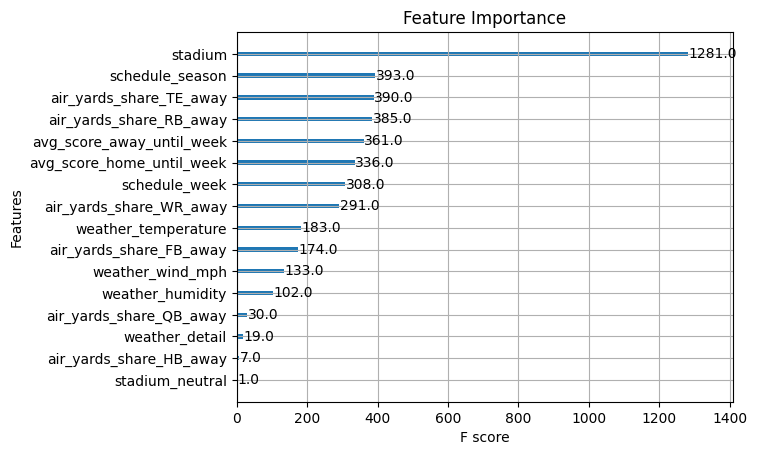

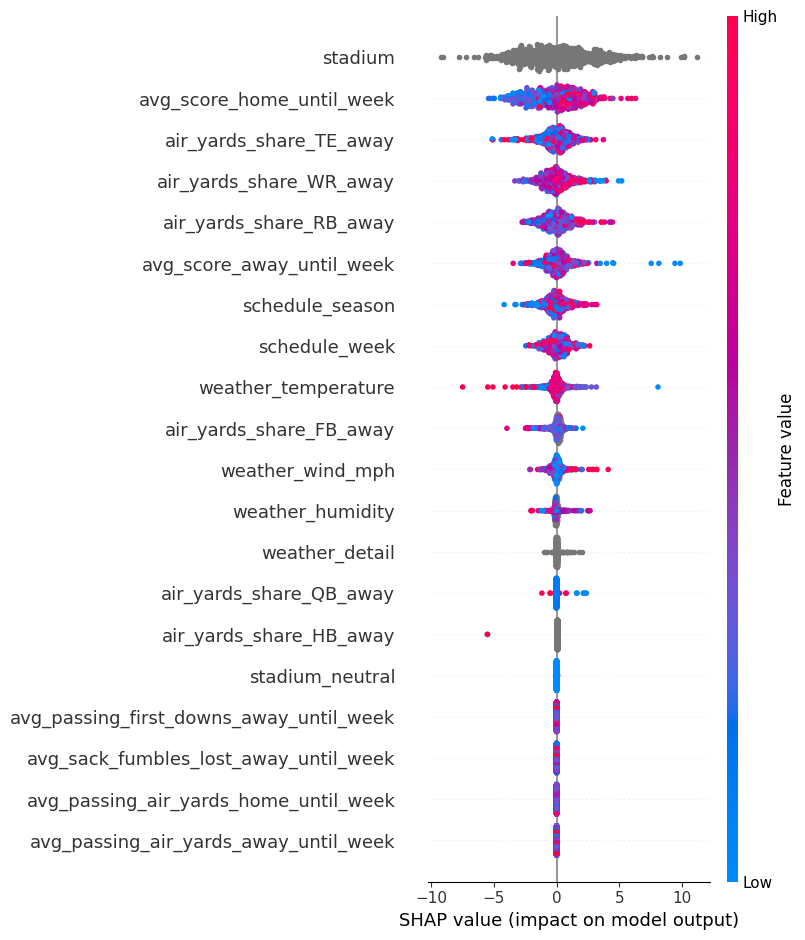

In [12]:
predictions_home = model.predict(X_test_home)

mse = mean_squared_error(y_test_home, predictions_home)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_home, predictions_home)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Feature importances
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

# SHAP values - Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test_home)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_home)

RMSE: 11.885098897910021
MAE: 9.367103464772057


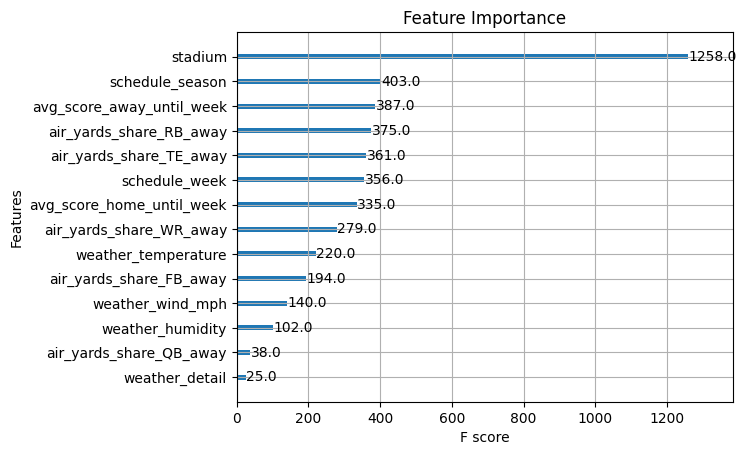

ImportError: matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.

In [40]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(X, y_away, random_state=42)
y_test_away = y_test_away.fillna(y_test_away.mean())


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_away = le.fit_transform(y_train_away)

model_away = xgb.XGBRegressor(use_label_encoder=True, 
                         eval_metric='logloss', 
                         enable_categorical=True)
                        # objective='multi:softprob')
model_away.fit(X_train_away, y_train_away)

predictions_away = model_away.predict(X_test_away)

mse = mean_squared_error(y_test_away, predictions_away)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_away, predictions_away)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Feature importances
xgb.plot_importance(model_away)
plt.title('Feature Importance')
plt.show()

# SHAP values - Explain the model's predictions using SHAP
explainer = shap.Explainer(model_away)
shap_values = explainer(X_test_away)

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_away)

In [33]:
y_train_home

2150    21.0
1891    24.0
497     28.0
1845    16.0
342     17.0
        ... 
1638    42.0
1095    28.0
1130     3.0
1294     7.0
860     17.0
Name: next_week_score_home, Length: 2033, dtype: float64

In [41]:
X_train_home.columns

Index(['schedule_season', 'schedule_week', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'air_yards_share_FB_away', 'air_yards_share_HB_away',
       'air_yards_share_QB_away', 'air_yards_share_RB_away',
       'air_yards_share_TE_away', 'air_yards_share_WR_away',
       'avg_score_home_until_week', 'avg_score_away_until_week',
       'avg_completions_home_until_week', 'avg_completions_away_until_week',
       'avg_attempts_home_until_week', 'avg_attempts_away_until_week',
       'avg_passing_yards_home_until_week',
       'avg_passing_yards_away_until_week', 'avg_passing_tds_home_until_week',
       'avg_passing_tds_away_until_week', 'avg_interceptions_home_until_week',
       'avg_interceptions_away_until_week', 'avg_sacks_home_until_week',
       'avg_sacks_away_until_week', 'avg_sack_yards_home_until_week',
       'avg_sack_yards_away_until_week', 'avg_sack_fumbles_home_until_week',
       'avg_sack_fumb

In [43]:
def evaluate_feature_subset(features):
    """
    Train and evaluate an XGBoost model using the specified subset of features.
    Returns the MAE of the model on the validation set.
    """
    model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42, enable_categorical=True)
    model.fit(X_train_home[features], y_train_home)
    y_pred = model.predict(X_test_home[features])
    print(mean_absolute_error(y_test_home, y_pred))
    return mean_absolute_error(y_test_home, y_pred)

# Start with an empty model (no features) and iteratively add features that improve performance
best_features = []
remaining_features = list(X.columns)
best_mae = np.inf

count = 0

while remaining_features:
    improvement = False
    for feature in remaining_features:
        trial_features = best_features + [feature]
        mae = evaluate_feature_subset(trial_features)
        print(f"Trying feature set {trial_features}, MAE: {mae}, count{count}")
        count += 1
        if mae < best_mae:
            best_mae = mae
            best_feature_to_add = feature
            improvement = True
    
    if improvement:
        best_features.append(best_feature_to_add)
        remaining_features.remove(best_feature_to_add)
        print(f"Added feature {best_feature_to_add}, New best MAE: {best_mae}")
    else:
        break  # Stop if no improvement

print(f"Best feature set: {best_features}, Best MAE: {best_mae}")

7.925451500929211
Trying feature set ['schedule_season'], MAE: 7.925451500929211, count0
8.034697107860824
Trying feature set ['schedule_week'], MAE: 8.034697107860824, count1
7.869114451000472
Trying feature set ['stadium'], MAE: 7.869114451000472, count2
7.994661010472121
Trying feature set ['stadium_neutral'], MAE: 7.994661010472121, count3
8.137857564782674
Trying feature set ['weather_temperature'], MAE: 8.137857564782674, count4
7.984220385903103
Trying feature set ['weather_wind_mph'], MAE: 7.984220385903103, count5
8.170786121206298
Trying feature set ['weather_humidity'], MAE: 8.170786121206298, count6
7.9952239090010835
Trying feature set ['weather_detail'], MAE: 7.9952239090010835, count7
8.341904586746981
Trying feature set ['air_yards_share_FB_away'], MAE: 8.341904586746981, count8
8.020943308298566
Trying feature set ['air_yards_share_HB_away'], MAE: 8.020943308298566, count9
8.042187718866849
Trying feature set ['air_yards_share_QB_away'], MAE: 8.042187718866849, count10

In [132]:
y_test_home

2684     0.0
2477    22.0
486      3.0
296     16.0
1362    35.0
        ... 
912     17.0
1701    24.0
618     30.0
406     27.0
1650    20.0
Name: next_week_score_home, Length: 678, dtype: float64

In [133]:
X_test_home['pred_home'] = predictions_home
X_test_home['pred_away'] = predictions_away

X_test_home['score_home'] = y_test_home
X_test_home['score_away'] = y_test_away

In [135]:
X_test_home['home_win'] = X_test_home.apply(lambda x: 1 if x.score_home > x.score_away else 0, axis=1)
X_test_home['pred_home_win'] = X_test_home.apply(lambda x: 1 if x.pred_home > x.pred_away else 0, axis=1)

In [138]:
df_test = X_test_home[['pred_home', 'pred_away', 'score_home', 'score_away', 'home_win', 'pred_home_win']]
df_test

,pred_home,pred_away,score_home,score_away,home_win,pred_home_win
2684,20.680500,12.060950,0.0,37.000000,0,1
2477,20.639505,17.168674,22.0,24.000000,0,1
486,18.919825,24.996899,3.0,19.000000,0,0
296,20.372473,26.562817,16.0,24.000000,0,0
1362,17.553282,20.723038,35.0,17.000000,1,0
...,...,...,...,...,...,...
912,13.595285,21.439892,17.0,30.000000,0,0
1701,23.768604,13.069775,24.0,6.000000,1,1
618,26.490005,31.869740,30.0,31.000000,0,0
406,13.052572,29.582039,27.0,21.000000,1,0


In [141]:
len(df_test[(df_test['home_win'] == 1)])

311

In [139]:
df_test[(df_test['pred_home_win'] == 1) & (df_test['home_win'] == 1)]

,pred_home,pred_away,score_home,score_away,home_win,pred_home_win
1544,26.533329,20.244562,37.0,18.0,1,1
318,16.918650,15.577732,34.0,7.0,1,1
1178,25.601427,23.741669,23.0,14.0,1,1
450,30.308109,27.779728,30.0,27.0,1,1
1912,20.023275,9.289899,30.0,9.0,1,1
...,...,...,...,...,...,...
2206,28.477909,19.877548,33.0,31.0,1,1
1508,19.487291,18.963446,28.0,27.0,1,1
1259,22.197872,21.709585,35.0,20.0,1,1
123,18.323782,8.749843,20.0,6.0,1,1


/var/folders/f8/x06ljxjn1p32rtq66ss8xtsr0000gn/T/ipykernel_23656/469991256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['home_residual'] = (df_test['pred_home'] - df_test['score_home'])


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  2.,  1.,  6.,  7.,  4., 10., 12., 17., 26., 20., 35., 25.,
        42., 31., 44., 31., 42., 40., 50., 30., 42., 29., 30., 16., 14.,
        17., 12., 12.,  9.,  3.,  3.,  4.,  2.,  1.,  1.,  5.]),
 array([-54.63388538, -52.95210405, -51.27032272, -49.58854139,
        -47.90676006, -46.22497873, -44.5431974 , -42.86141607,
        -41.17963474, -39.49785341, -37.81607208, -36.13429075,
        -34.45250942, -32.77072809, -31.08894676, -29.40716543,
        -27.7253841 , -26.04360277, -24.36182144, -22.68004011,
        -20.99825878, -19.31647745, -17.63469612, -15.95291479,
        -14.27113346, -12.58935213, -10.9075708 ,  -9.22578947,
         -7.54400814,  -5.86222681,  -4.18044548,  -2.49866415,
         -0.81688282,   0.86489851,   2.54667984,   4.22846117,
          5.9102425 ,   7.59202383,   9.27380516,  10.95558649,
         12.63736782,  14.31914915,  16.00093048,  17.68271181,
         19.

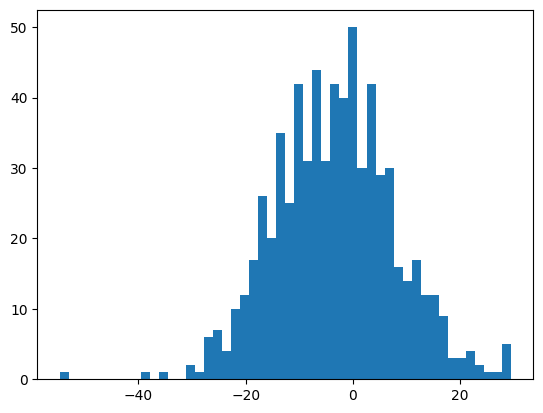

In [144]:
df_test['home_residual'] = (df_test['pred_home'] - df_test['score_home'])

plt.hist(df_test['home_residual'], bins = 50)

Confusion Matrix:
[[239 128]
 [177 134]]


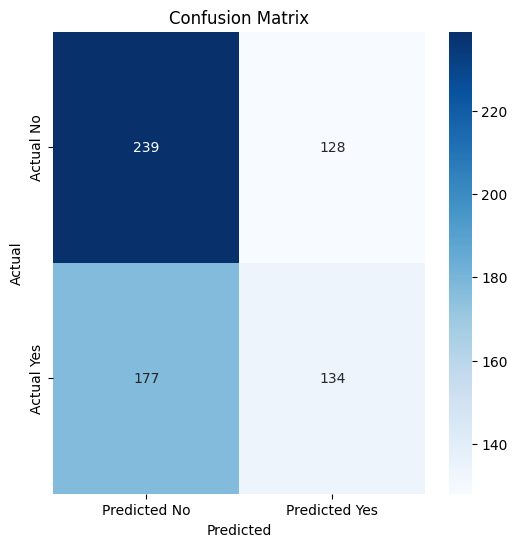

In [150]:
cm = confusion_matrix(df_test['home_win'], df_test['pred_home_win'])

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Plotting the confusion matrix using seaborn for better visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [39]:
auc_score = roc_auc_score(df_test['home_win'], df_test['pred_home_win'])

print(f"AUC: {auc_score}")

fpr, tpr, thresholds = roc_curve(df_test['home_win'], df_test['pred_home_win'])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'df_test' is not defined